<a href="https://colab.research.google.com/github/ljishen/my-notebooks/blob/master/possibility_of_data_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will analyze the possibility of failure for each of the following two deployments/setups. The first deployment uses general-purpose servers to build edge storage systems. While the second deployment uses a different type of element, Eusocial Storage Device, to construct edge storage system.

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vSLUfHP-I2tvNaqcGzScy3mtlImrJ3OF3QUrfeGrdir7SF_VIksoJaIg--3bI2Zj5noH1jk3-kyHj-w/pub?w=838&h=518)

This analysis will focus on comparing the possibility of failure of these two systems. A failure, in this context, means any chunk of data becomes irretrievably lost because of hardware failure. Note that the software failure is out of this comparision.

It is challenging to compare two storage systems with dramatically different hardware configurations. To enable an effective comparison, we need to make a couple of configuration assumptions so that the two systems are directly comparable:

> **System Configuration Assumptions**
1. The deployment units are homogeneous. In other words, all the GP servers are having the same hardware configuration. Similarly, all the Eusocial Storage Devices are exactly the same model.
1. These two systems has the same level of network redundancy and power redundancy for all nodes.
1. Both of the deployments use the state-of-the-art **3-ways replication** for data protection, meaning each data chunk has 3 replicas somewhere in the cluster. The replication strategy depends on the replication scheme applied on the systems.
1. Instead of using the random replication as the scheme, we apply a different replication scheme, called **Copyset Replication** [1], on to the two storage systems. The reasons are:
    1. Random replication is a simple technique that is used in many production storage systems like  Hadoop Distributed File System (HDFS), Google File System (GFS), and Windows Azure. It can protect data from uncorrelated failures like individual servers or disks failures. However, it is not good at providing strong data protection from correlated failures in that multiple servers or disks fail simultaneously. For example, power outage or network connection problems will likely cause such correlated failures. With sufficient data chunks to store, if the storage system is configured to be 3-ways replication using random replication scheme, any combination of 3 servers would be members of replicas of at least one data chunk. Therefore, losing any three servers would inevitably result in data loss. The fundamental reason of data loss using random replication is that it creates a topology in that every server has connections to almost all the other servers in the network.
    1. In contrary to the random replication, copyset replication minimizes the possibility of data loss against correlated failures by reducing the number of servers that shares copies of the data on a server. While this replication technique may cause larger amount of data lost in the event of failure, many companies and storage system engineers prefer this scheme over the traditional random replication because it can significantly reduce the possibility of data loss. It is reported that for small amount of data lost, the cost of data recovery is irrelevant to the amount of data lost since the cost is mainly driven by a fixed amount labor hours to recompute the data. Copyset replication has two phases. The first phase is to generate a list of copysets of the same size. This phase is to be conducted offline. The second phase is used when data is being replicated. For each data chunk, the storage system needs to choose a primary server to store the data. Once the primary server is chosen, the corresponding copyset of the data chunk could be selected from the ones that contains the primary server. Since each copyset defines a failure domain, the loss of a copyset would result in an irretrievable loss of the corresponding data chunks.


[1] Cidon, Asaf, et al. "Copysets: Reducing the frequency of data loss in cloud storage." Presented as part of the 2013 {USENIX} Annual Technical Conference ({USENIX}{ATC} 13). 2013.

Suppose we use the following symbols for our mathematical analysis:

| Name |                 Description
|:----:|:-------------------------------------------|
|   $ \boldsymbol{m} $  | the number of GP servers in the storage system |
|   $ \boldsymbol{m}^{'} $  | the number of Eusocial Storage Devices in the storage system |
|   $ \boldsymbol{n} $  | the number of storage devices in a GP server   |
|   $ \boldsymbol{P_{m}} $  | the possibility of failure of components except the storage devices in a GP server  |
|   $ \boldsymbol{P_{d}} $  | the possibility of failure of a storage device in a GP server  |
|   $ \boldsymbol{P_{m}^{'}} $  | the possibility of failure of components except the storage devices in a Eusocial Storage Device  |
|   $ \boldsymbol{P_{d}^{'}} $  | the possibility of failure of a storage device in a Eusocial Storage Device  |

for simplicity, we have the following parameters assumptions:

> **Parameters Assumptions**
1. We will use scatter width $ W = 4 $, and copyset size $ R = 3 $ as the scheme parameters for the copyset replication. That means,
    - any single data chunk would be replicated on servers in a specific copyset, and
    - the data chunks on a server could be replicated to 3 other different servers (thus the scatter width is $ 4 $).
1. We follow the same way as discussed in the paper to construct the copysets for all nodes in the cluster:
    1. Generate $ \frac{W}{R - 1}  = 2 $ permutations for all m nodes.
    1. Split each permutation into copysets so that each copyset has three nodes. For example, $ \{1,2,3\},\{4,5,6\},\{7,8,9\},...,\{1,4,7\},\{2,5,8\},\{3,6,9\},... $. \\
    Therefore, thare are a total of $ \frac{W}{R - 1} * \frac{m}{R} = \frac{2m}{R} $ copysets.
1. $ \boldsymbol{P_m} = \boldsymbol{P_m^{'}} $ and $ \boldsymbol{P_d} = \boldsymbol{P_d^{'}} $. Though many literatures suggest that $ \boldsymbol{P_m} $ would be much greater than $ \boldsymbol{P_m^{'}} $ since GP servers has a much more complex design which increases the failure surface. However, with this assumption we can produce a conservative result that creates a baseline of possibility of failure from our analysis.
1. $ \boldsymbol{P_d} = f \cdot \boldsymbol{P_m} $, where $ f > 0 $. The actual $ f $ depends on the type of storage devices in use. For hard drives, $ f $ could be greater than 2. While for solid-state drives, $ f $ could be less than 1. We call $ f $ the **ratio of failure rates**.
1. $ \boldsymbol{m^{'}} = c \cdot \boldsymbol{m} $, where $ c >= 1 $. Because a Eusocial Storage Device is in general less computing capable than a GP server due to the limited available space in their form factors to package abundant computing resources. We call $ c $ the **ratio of computing performance**.
1. $ \boldsymbol{n} = s \cdot \boldsymbol{m} $, where $ s >= 2 $. Each GP server has $ r $ storage devices in it. We call $ s $ the **ratio of storage performance**.
1. $ \boldsymbol{m} >= 3 $. Because 3-way replication requires at least 3 separate failure domains, which needs 3 servers.
1. Each Eusocial Storage Device is built with one storage device and some extra computing resources.

Given the symbols above,  we can express the possibility of failure $ \boldsymbol{P_{gp}} $ for the storage system built with GP servers:

> $ \boldsymbol{P_{gp}} = \mathrm{C}_\boldsymbol{m}^2 \cdot {\boldsymbol{P_m}}^2 + \mathrm{C}_{\boldsymbol{m} \cdot \boldsymbol{n}}^2 \cdot {\boldsymbol{P_d}}^2 - \boldsymbol{m} \cdot \mathrm{C}_\boldsymbol{n}^2 \cdot {\boldsymbol{P_d}}^2 $

The first term represents the possibility of failure of any two GP servers. The second term represents the possibility of failure of any two storage devices in the storage system. According to our assumption, a failure of two storage devices belonging to the same failure domain does not lead to data loss. Therefore, the third term subtracts the possibilities from these cases.

On the other hand, the possibility of failure $ \boldsymbol{P_{esd}} $ for the storage system built with Eusocial Storage Devices can be expressed as follows:

> $ \boldsymbol{P_{esd}} = \mathrm{C}_\boldsymbol{m^{'}}^2 \cdot {\boldsymbol{P_m^{'}}}^2 + \mathrm{C}_\boldsymbol{m^{'}}^2 \cdot {\boldsymbol{P_d^{'}}}^2 $

Since we assume $ \boldsymbol{P_m} = \boldsymbol{P_m^{'}} $ and $ \boldsymbol{P_d} = \boldsymbol{P_d^{'}} $, the equation can be rewritten as

> $ \boldsymbol{P_{esd}} = \mathrm{C}_\boldsymbol{m^{'}}^2 \cdot {\boldsymbol{P_m}}^2 + \mathrm{C}_\boldsymbol{m^{'}}^2 \cdot {\boldsymbol{P_d}}^2 =
 \mathrm{C}_\boldsymbol{m^{'}}^2 \cdot ({\boldsymbol{P_m}}^2 + {\boldsymbol{P_d}}^2) $

To evaluate the benefit of the reduction of the failure domain that Eusocial Storage Devices can bring about, we want to calculate the radio between $ \boldsymbol{P_{gp}} $ and $ \boldsymbol{P_{esd}} $:

> \begin{align*}
\frac{\boldsymbol{P_{gp}}}{\boldsymbol{P_{esd}}}
&= \frac{\mathrm{C}_\boldsymbol{m}^2 \cdot {\boldsymbol{P_m}}^2 + \mathrm{C}_{\boldsymbol{m} \cdot \boldsymbol{n}}^2 \cdot {\boldsymbol{P_d}}^2 - \boldsymbol{m} \cdot \mathrm{C}_\boldsymbol{n}^2 \cdot {\boldsymbol{P_d}}^2}{\mathrm{C}_\boldsymbol{m^{'}}^2 \cdot ({\boldsymbol{P_m}}^2 + {\boldsymbol{P_d}}^2)} \\
&= \frac{\boldsymbol{m} \cdot (\boldsymbol{m} - 1) \cdot ({\boldsymbol{P_m}}^2 + {\boldsymbol{n}}^2 \cdot {\boldsymbol{P_d}}^2)}{\boldsymbol{m^{'}} \cdot (\boldsymbol{m^{'}} - 1) \cdot ({\boldsymbol{P_m}}^2 + {\boldsymbol{P_d}}^2)}
\end{align*}

After pluging into our assumptions, we get

> \begin{align*}
\frac{\boldsymbol{P_{gp}}}{\boldsymbol{P_{esd}}} = \frac{\boldsymbol{m} \cdot (\boldsymbol{m} - 1) \cdot (1 + s^2 \cdot {\boldsymbol{m}}^2 \cdot f^2)}{c \cdot \boldsymbol{m} \cdot (c \cdot \boldsymbol{m} - 1) \cdot (1 + f^2)}
\end{align*}
where $ f > 0 $, $ c >= 1 $, and $ s > 1 $.

In [1]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
import matplotlib.pyplot as plt # see https://github.com/ipython/ipython/issues/11098

In [2]:
import itertools
import numpy as np
import math

# Double resolution plot output for retina screens.
# Just be aware that this won’t render on non-retina screens.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

matplotlib.rcParams['figure.figsize'] = [18, 8]
matplotlib.rcParams["font.size"] = 15
labelpad = 10


w = 4

def r_m():
    return 1

def r_m_prime():
    return r_m()

def r_d_prime(f):
    return r_d(f)

def r_d(f):
    return f * r_m()

def m_prime(m, c):
    return m * c

def l_gp(m):
    return math.ceil(w * m / 6)

def l_es(m, c):
    return math.ceil(w * m_prime(m, c) / 6)

# we need at least 3 GP servers because we are doing 3-way replication
m = np.arange(3, 11)


def poisson(lam, k):
    return math.pow(lam, k) * math.exp(-1 * lam) / math.factorial(k)

def combinations(n, m):
    return math.factorial(n) / (math.factorial(m) * math.factorial(n - m))

def p_m(m, k):
    return poisson(r_m(), k) * l_gp(m) / combinations(m, k)

def p_d(m, n, j, f):
    return poisson(r_d(f), j) * n * l_gp(m) / combinations(n * m, j)

def p_md(m, n, k, j, f):
    return poisson(r_m(), k) * poisson(r_d(f), j) * 3 * n * l_gp(m) / (combinations(m, k) * combinations(n * m, j))

def p_m_prime(m, c, k):
    return poisson(r_m_prime(), k) * l_es(m, c) / combinations(m_prime(m, c), k)

def p_d_prime(m, c, j, f):
    return poisson(r_d_prime(f), j) * l_es(m, c) / combinations(m_prime(m ,c), j)

def p_md_prime(m, c, k, j, f):
    return poisson(r_m_prime(), k) * poisson(r_d_prime(f), j) * 3 * l_es(m, c) / (combinations(m_prime(m, c), k) * combinations(m_prime(m ,c), j))

def ratio(m, c, n, f):
    return (p_m(m, 3) + p_d(m, n, 3, f) + p_md(m, n, 1, 2, f) + p_md(m, n, 2, 1, f)) \
            / (p_m_prime(m, c ,3) + p_d_prime(m, c, 3, f) + p_md_prime(m, c, 1, 2, f) + p_md_prime(m, c, 2, 1, f))

Let's plot this function by applying some real values for parameters $ f $, $ c $, and $ s $.

First, we assign a fixed value to $ c $, so we can see the relationship between the remaining two variables $ \boldsymbol{m} $ and $ s $.

In [3]:
def plot_m_vs_n(f, zlimits):
    n = np.arange(2, 20)
    M, N = np.meshgrid(m, n)

    R = np.empty([M.shape[0], M.shape[1]], dtype=int)
    C = np.empty([M.shape[0], M.shape[1]], dtype=int)
    for idx in range(0, M.shape[0]):
        for idy in range(0, M.shape[1]):
            R[idx, idy] = ratio(M[idx, idy], c=N[idx, idy], n=N[idx, idy], f=f)

    ax = plt.subplot(projection='3d')

    ax.plot_wireframe(M, N, R, cmap='viridis')
    ax.scatter3D(M, N, R)

    annotate_points = list(itertools.product(m[-4:], n[2::2]))
    annotate_points.extend(itertools.product(m, n[0:1]))

    for _m, _n in annotate_points:
        _r = ratio(_m, _n, _n, f)
        label = '%d, %d, %.1f' % (_m, _n, _r)
        ax.text(_m, _n, _r, label, ha='center',
                size=10, bbox=dict(facecolor='pink', alpha=0.3))

    ax.set_zlim3d(zlimits)
    ax.set_yticks(n[::2])
    ax.view_init(40, -35)

    ax.set_xlabel(r'Number of GP servers ($ m $)', labelpad=labelpad * 1.5)
    ax.set_ylabel(r'Number of Storage Devices per Server ($ n $)', labelpad=labelpad * 1.5)
    ax.set_zlabel(r"Relative Benefit", labelpad=labelpad)

    plt.savefig('edge_storage_systems_m_vs_n_' + str(f) + '.svg', bbox_inches='tight')
    plt.show()

Next, we can assign a fixed value to $ s $, so we can see the relationship between the remaining two variables $ \boldsymbol{m} $ and $ c $.

In [4]:
def plot_m_vs_c(f, zlimits):
    n = 12

    c = np.arange(1, 20)
    M, C = np.meshgrid(m, c)

    R = np.empty([M.shape[0], M.shape[1]], dtype=int)
    for idx in range(0, M.shape[0]):
        for idy in range(0, M.shape[1]):
            R[idx, idy] = ratio(M[idx, idy], c=C[idx, idy], n=n, f=f)

    ax = plt.subplot(projection='3d')

    ax.plot_wireframe(M, C, R, cmap='viridis')
    ax.scatter3D(M, C, R)

    annotate_points = list(itertools.product(m, c[:19:4]))
    annotate_points.extend(itertools.product(m, c[-1:]))

    for _m, _c in annotate_points:
        _r = ratio(_m, _c, n, f)
        label = '%d, %d, %.1f' % (_m, _c, _r)
        ax.text(_m, _c, _r, label, ha='center',
                size=10, bbox=dict(facecolor='pink', alpha=0.3))

    ax.set_zlim3d(zlimits)
    ax.set_yticks(c[::2])
    ax.view_init(40, -65)

    ax.set_xlabel(r'Number of GP Servers ($ m $)', labelpad=labelpad * 1.5)
    ax.set_ylabel(r'Ratio of Computing Performance ($ c $)', labelpad=labelpad * 1.5)
    ax.set_zlabel(r"Relative Benefit", labelpad=labelpad)

    plt.savefig('edge_storage_systems_m_vs_c_' + str(f) + '.svg', bbox_inches='tight')
    plt.show()

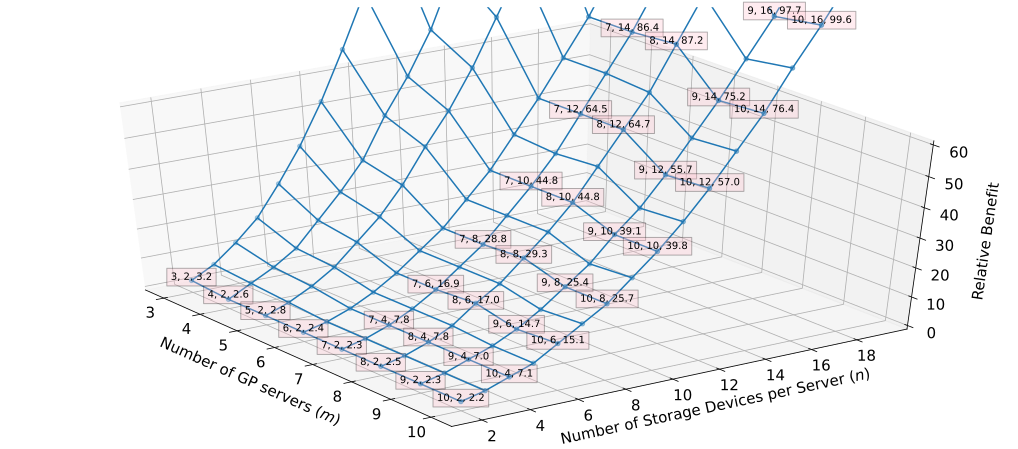

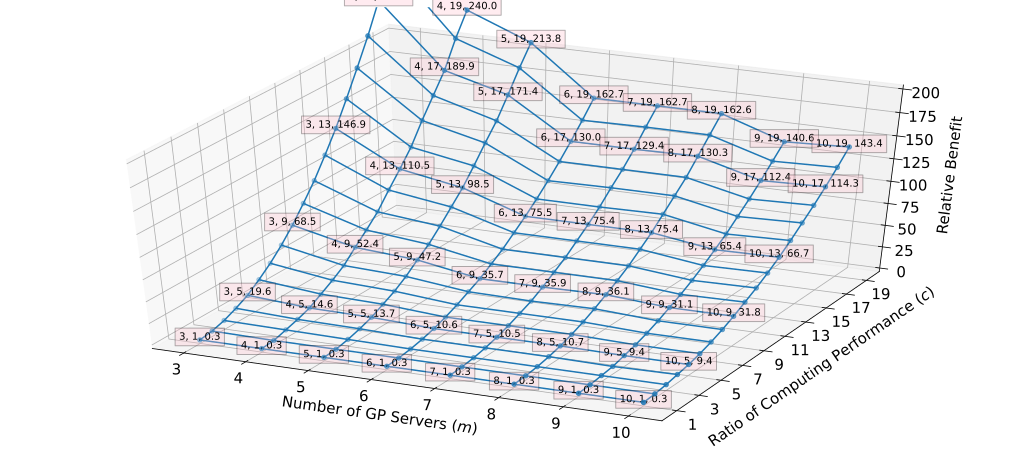

In [5]:
# Vishwanath, Kashi Venkatesh, and Nachiappan Nagappan.
#   "Characterizing cloud computing hardware reliability."
#   Proceedings of the 1st ACM symposium on Cloud computing. 2010.
# => "70% of all server failures is due to hard disks"
hdd_f = 2     # for hard drives

plot_m_vs_n(hdd_f, [0, 60])
plot_m_vs_c(hdd_f, [0, 200])

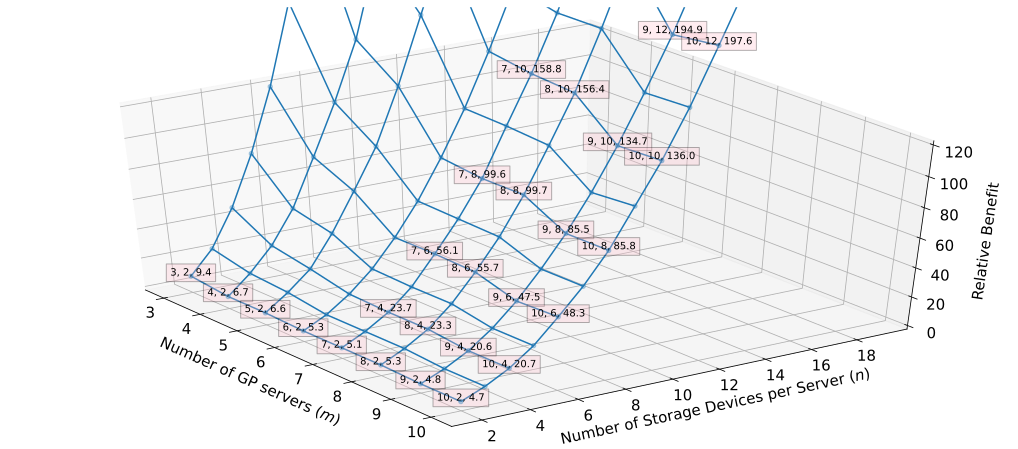

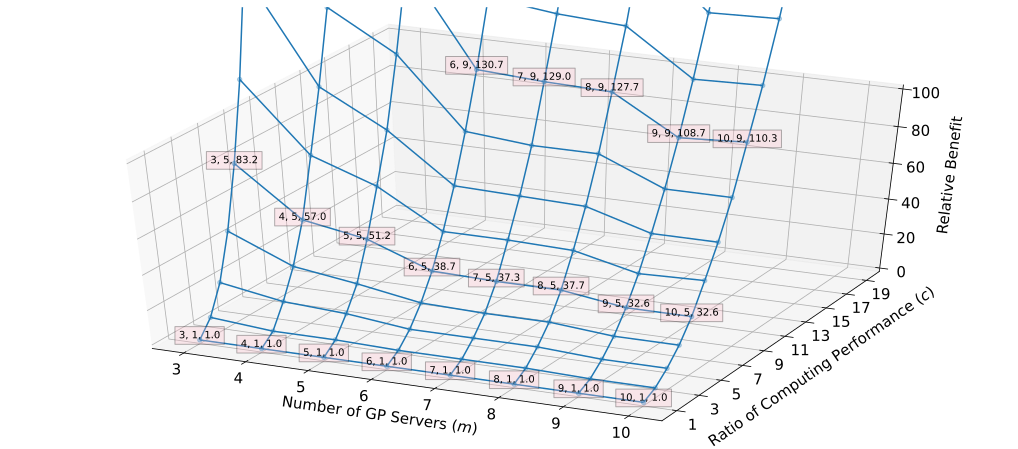

In [6]:
# Xu, Erci, et al.
#   "Lessons and actions: What we learned from 10k ssd-related storage system failures."
#   2019 {USENIX} Annual Technical Conference ({USENIX}{ATC} 19). 2019.
# => SSD-related tickets account for 5.6% of all hardware issues.
ssd_f = 0.06  # for SSD

plot_m_vs_n(ssd_f, [0, 120])
plot_m_vs_c(ssd_f, [0, 100])

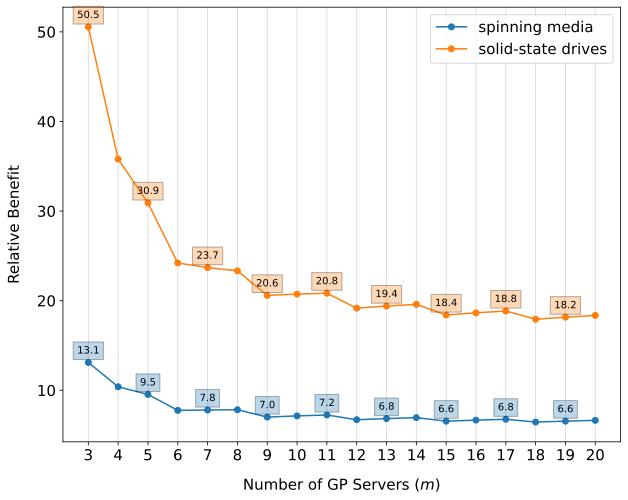

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

n = 4
mr = np.arange(3, 21)

def plot_m_vs_ratio(f, color, label, txt_offset):
    rr = np.empty(len(mr), dtype=float)
    for i in range(len(mr)):
        rr[i] = ratio(mr[i], n, n, f)

        if i % 2 == 0:
            ax.text(mr[i], rr[i] + txt_offset, '%.1f' % rr[i], ha='center',
                    size=10, bbox=dict(facecolor=color, alpha=0.3))

    ax.plot(mr, rr, '-o', color=color, label=label)


plot_m_vs_ratio(hdd_f, 'C0', 'spinning media', 1)
plot_m_vs_ratio(ssd_f, 'C1', 'solid-state drives', 1)

ax.set_xticks(mr)
ax.xaxis.grid(alpha=0.5)

ax.set_xlabel(r'Number of GP Servers ($ m $)', labelpad=labelpad * 1.5)
ax.set_ylabel(r"Relative Benefit", labelpad=labelpad * 1.5)

ax.legend()
plt.savefig('edge_storage_systems_m_vs_ratio.svg', bbox_inches='tight')

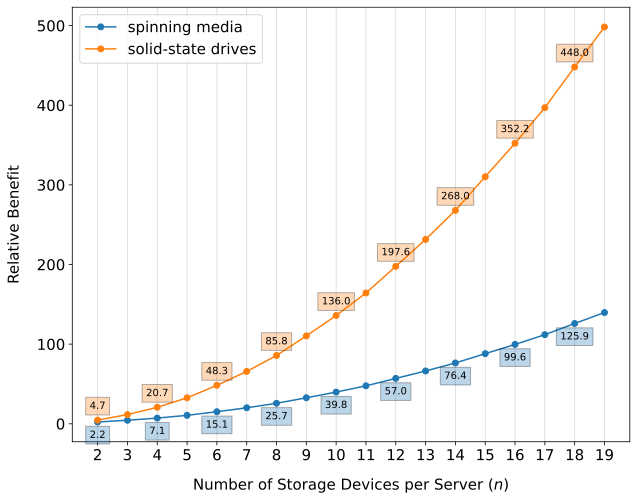

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

num_servers = 10
nr = np.arange(2, 20)

def plot_n_vs_ratio(f, color, label, txt_offset):
    rr = np.empty(len(nr), dtype=float)
    for i in range(len(nr)):
        rr[i] = ratio(num_servers, nr[i], nr[i], f)

    ax.plot(nr, rr, '-o', color=color, label=label)

    for i in range(len(nr) // 2):
        cur_i = i * 2
        ax.text(nr[cur_i], rr[cur_i] + txt_offset, '%.1f' % rr[cur_i], ha='center',
                size=10, bbox=dict(facecolor=color, alpha=0.3))


plot_n_vs_ratio(hdd_f, 'C0', 'spinning media', -20)
plot_n_vs_ratio(ssd_f, 'C1', 'solid-state drives', 14)

ax.set_xticks(nr)
ax.xaxis.grid(alpha=0.5)

ax.set_xlabel(r'Number of Storage Devices per Server ($ n $)', labelpad=labelpad * 1.5)
ax.set_ylabel(r"Relative Benefit", labelpad=labelpad * 1.5)

ax.legend()
plt.savefig('edge_storage_systems_n_vs_ratio.svg', bbox_inches='tight')

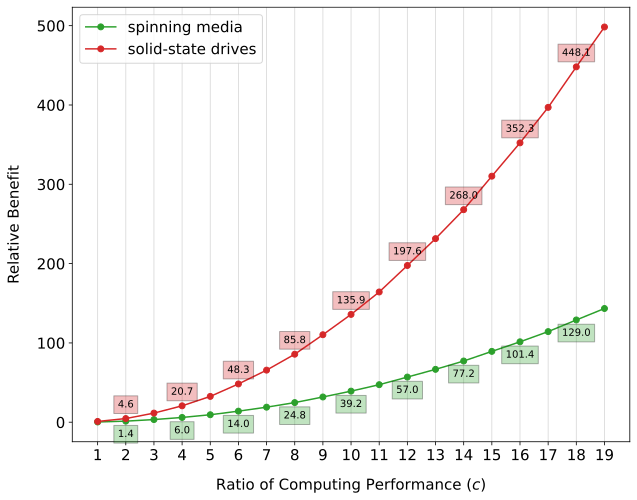

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

num_servers = 10
n = 12
cr = np.arange(1, 20)

def plot_c_vs_ratio(f, color, label, txt_offset):
    rr = np.empty(len(cr), dtype=float)
    for i in range(len(cr)):
        rr[i] = ratio(num_servers, cr[i], n, f)

    ax.plot(cr, rr, '-o', color=color, label=label)

    for i in range(len(cr) // 2):
        cur_i = i * 2 + 1
        ax.text(cr[cur_i], rr[cur_i] + txt_offset, '%.1f' % rr[cur_i], ha='center',
                size=10, bbox=dict(facecolor=color, alpha=0.3))


plot_c_vs_ratio(hdd_f, 'C2', 'spinning media', -20)
plot_c_vs_ratio(ssd_f, 'C3', 'solid-state drives', 14)

ax.set_xticks(cr)
ax.xaxis.grid(alpha=0.5)

ax.set_xlabel(r'Ratio of Computing Performance ($ c $)', labelpad=labelpad * 1.5)
ax.set_ylabel(r"Relative Benefit", labelpad=labelpad * 1.5)

ax.legend()
plt.savefig('edge_storage_systems_c_vs_ratio.svg', bbox_inches='tight')